In [14]:
import re

import xml.etree.ElementTree

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Reading and cleaning data

In [2]:
e = xml.etree.ElementTree.parse('recipeBaseCompulsory_clean.xml').getroot()

recipe_ingredients = []
recipe_title = []

for atype in e.findall('RECIPE'):
    ingredients = []
    
    recipe_title.append(atype.find('TI').text)
    
    for i in atype.findall('IN'):
        try:
            ingredients.append(i.text)
        except Exception:
            pass
    
    recipe_ingredients.append(ingredients)

In [3]:
tokenizer = RegexpTokenizer(r'\w+')
porter = PorterStemmer()
stop_words = stopwords.words("english") 
stop_words.extend(['ounce', 'skinless', 'boneless', 'halves', 'cold', 'sized',
                   'cooked', 'unseasoned', 'colored', 'light', 'medium', 'thinly',
                   'coarsely', 'crushed', 'whole', 'recipe', 'pitted', 'bing'])

recipe_ingredients_clean = []
recipe_title_clean = []

for rec_tit in recipe_title:
    t = rec_tit.lower()
    words = tokenizer.tokenize(t)

    recipe_title_clean.append(' '.join([word for word in words 
                                       if word not in stop_words
                                       and not word.isdigit() 
                                       and len(word) > 3]))

recipe_title_clean = list(filter(None, recipe_title_clean))

    
for rec_ing in recipe_ingredients:
    ingredients_clean = []
    
    for ing in rec_ing:
        t = ing.lower()
        t = re.sub("[\(\[].*?[\)\]]", "", t) # Remove brackets
        t = t.split(',')[0]
        t = t.split(';')[0]
        t = t.split(' or ')[0]

        words = tokenizer.tokenize(t)

        ingredients_clean.append(' '.join([word for word in words 
                                           if word not in stop_words
                                           and not word.isdigit() 
                                           and len(word) > 3]))
        
    ingredients_clean = list(filter(None, ingredients_clean))
    recipe_ingredients_clean.append(ingredients_clean)

<br>
# Association Rules

Una regla de asociación busca regularidades en los datos. Intenta asociar datos, objetos, eventos... que aparecen juntos para buscar patrones, asociaciones o correlaciones.

El recuento ($\sigma$) es el número de veces que aparece un itemset en el dataset.

El soporte de la regla ($s$) es la probabilidad de que una transacción contenga a $X$ y a $Y$:

$$ s(X \rightarrow Y) = \frac{\sigma(X, Y)}{T} $$

La confianza de la regla ($c$) es la probabilidad de que una transacción que contenga a $X$ también contenga a $Y$:

$$ c(X \rightarrow Y) = \frac{\sigma(X, Y)}{\sigma(X)} $$

El algoritmo Apriori sirve para reducir los candidatos a itemset frecuente. Se basa en la pripiedad de que si un itemset no es frecuente, tampoco lo serán sus supersets; mientras que si un itemset es frecuente, también lo serán sus subconjuntos.

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

<br>
## All dataset

In [18]:
te = TransactionEncoder()
te_ary = te.fit(recipe_ingredients_clean).transform(recipe_ingredients_clean)

df_transactions = pd.DataFrame(te_ary, columns=te.columns_)
df_transactions.head()

,accent,acorn squash,across bone inch thick,acrylic paints,active dried yeast,active yeast,active yeast star,active yeast warm water,acuavit,additional butter,...,zampone sausage,zest,zinfandel reduction sauce,zinfandel wine,ziti,zucchini,zucchini pieces,zucchini sliced rings,zucchinis,zuchinni
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
frequent_itemsets = apriori(df_transactions, min_support=0.003, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)

rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
len(rules)

14838

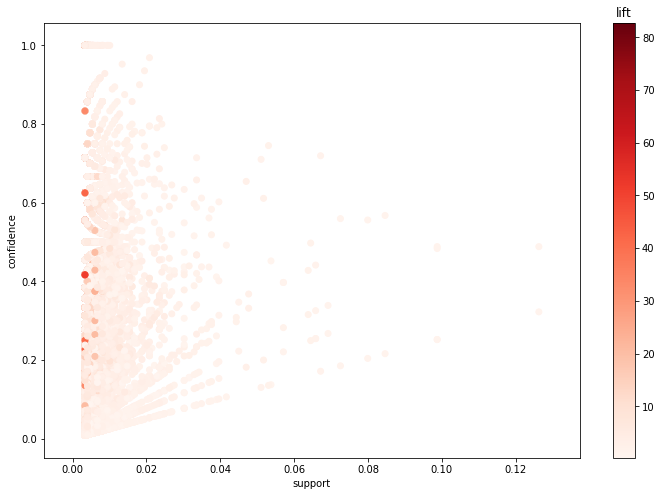

In [61]:
def plot_arules(assoc_rules, measure=('support', 'confidence'), shading=None):
    X = assoc_rules[measure[0]]
    y = assoc_rules[measure[1]]
    
    c = shading
    cmap = None
    if shading is not None:
        c = assoc_rules[shading]
        cmap = 'Reds'
    
    plt.scatter(X, y, c=c, cmap=cmap)
    plt.xlabel(measure[0])
    plt.ylabel(measure[1])
    
    if shading is not None:
        col_bar = plt.colorbar()
        col_bar.ax.set_title(shading)
    
    
plot_arules(rules, shading='lift')

<br>
## With min_support and confidence limit

In [4]:
te = TransactionEncoder()
te_ary = te.fit(recipe_ingredients_clean).transform(recipe_ingredients_clean)

df_transactions = pd.DataFrame(te_ary, columns=te.columns_)
df_transactions.head()

,accent,acorn squash,across bone inch thick,acrylic paints,active dried yeast,active yeast,active yeast star,active yeast warm water,acuavit,additional butter,...,zampone sausage,zest,zinfandel reduction sauce,zinfandel wine,ziti,zucchini,zucchini pieces,zucchini sliced rings,zucchinis,zuchinni
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
frequent_itemsets = apriori(df_transactions, min_support=0.03, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets[frequent_itemsets.length > 1]

,support,itemsets,length
34,0.031565,"[baking powder, flour]",2
35,0.033580,"[baking powder, milk]",2
36,0.051041,"[baking powder, salt]",2
37,0.047011,"[baking powder, sugar]",2
38,0.044997,"[butter, eggs]",2
39,0.063801,"[butter, flour]",2
40,0.057085,"[butter, milk]",2
41,0.098724,"[butter, salt]",2
42,0.065816,"[butter, sugar]",2
43,0.034251,"[butter, vanilla]",2


In [6]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
rules

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedant_len
0,(eggs),(butter),0.129617,0.202149,0.044997,0.347150,1.717298,0.018795,1.222105,1
1,(cinnamon),(sugar),0.055071,0.258563,0.032908,0.597561,2.311086,0.018669,1.842359,1
2,(eggs),(salt),0.129617,0.391538,0.072532,0.559585,1.429199,0.021782,1.381567,1
3,(pepper),(salt),0.093351,0.391538,0.067159,0.719424,1.837432,0.030609,2.168621,1
4,(sugar),(salt),0.258563,0.391538,0.126259,0.488312,1.247163,0.025022,1.189126,1
5,(salt),(sugar),0.391538,0.258563,0.126259,0.322470,1.247163,0.025022,1.094324,1
6,(purpose flour),(sugar),0.071189,0.258563,0.030222,0.424528,1.641877,0.011815,1.288399,1
7,(vanilla),(sugar),0.084621,0.258563,0.051713,0.611111,2.363492,0.029833,1.906553,1
8,(butter),(sugar),0.202149,0.258563,0.065816,0.325581,1.259197,0.013548,1.099372,1
9,(baking powder),(salt),0.071860,0.391538,0.051041,0.710280,1.814078,0.022905,2.100175,1


<br>
## Fish

In [7]:
fish_words = ['fish', 'seafood', 'snapper', 'tuna', 'bluefish', 
              'shark', 'croaker', 'flounder', 'trout']

fish_recipes_idx = [i for i, e in enumerate(recipe_title_clean) for x in fish_words if x in e]
fish_recipes_ingredients = list(np.asarray(recipe_ingredients_clean)[fish_recipes_idx])

In [8]:
te = TransactionEncoder()
te_ary = te.fit(fish_recipes_ingredients).transform(fish_recipes_ingredients)

df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

In [9]:
frequent_itemsets = apriori(df_transactions, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
rules

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedant_len
0,(fish stock),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf,1
1,(lemon juice),(salt),0.130435,0.326087,0.086957,0.666667,2.044444,0.044423,2.021739,1
2,(parsley),(flour),0.086957,0.152174,0.065217,0.750000,4.928571,0.051985,3.391304,1
3,(honey),(salt),0.065217,0.326087,0.065217,1.000000,3.066667,0.043951,inf,1
4,(cornstarch),(salt),0.086957,0.326087,0.065217,0.750000,2.300000,0.036862,2.695652,1
5,"(butter, flour)",(salt),0.086957,0.326087,0.065217,0.750000,2.300000,0.036862,2.695652,2
6,"(butter, salt)",(flour),0.108696,0.152174,0.065217,0.600000,3.942857,0.048677,2.119565,2
7,"(flour, salt)",(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf,2
8,(vinegar),(worcestershire sauce),0.108696,0.130435,0.065217,0.600000,4.600000,0.051040,2.173913,1
9,(leaf),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf,1
